In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sacc
import os
from scipy import stats

# Real space measurements Gaussian sims

In [2]:
def make_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [14]:
dir = '../data_vectors/gaussian_sims/071222/area12300/July14/' # this is what is used in the chains. 
#dir = '../data_vectors/gaussian_sims/071222/area12300/Oct19/' # this new run is consistent but it has a different shape noise realization. 

file = dir +'twopoint_data_real.sacc'
d = sacc.Sacc.load_fits(file)

file = dir + 'twopoint_theory_real.sacc'
t = sacc.Sacc.load_fits(file)

file = dir + 'summary_statistics_real.sacc' # this covariance is scaled for the shot noise due to the scaling factor for the gaussian sims
t_cov_s = sacc.Sacc.load_fits(file)
make_directory(dir + 'plots/')

#dir2 = '../data_vectors/gaussian_sims/071222_run2/area12300/July14/'
dir2 = '../data_vectors/gaussian_sims/071222_run2/area12300/Nov7/'
file = dir2 + 'twopoint_data_real.sacc' #already scaled by gaussians sims factor # JK covariance is not scaled though. 
d2 = sacc.Sacc.load_fits(file)

file = dir2 + 'twopoint_theory_real.sacc'
t2 = sacc.Sacc.load_fits(file)

file = dir2 + 'summary_statistics_real.sacc' # this covariance is scaled for the shot noise due to the scaling factor for the gaussian sims
t2_cov_s = sacc.Sacc.load_fits(file)


make_directory(dir2 + 'plots/')

for dt in d.get_data_types():
        print(dt)
print ('----')
for dt in t.get_data_types():
        print(dt)
print ('----') 

W = "galaxy_density_xi"
GAMMA = "galaxy_shearDensity_xi_t"
GAMMAX = "galaxy_shearDensity_xi_x"
XIP = "galaxy_shear_xi_plus"
XIM = "galaxy_shear_xi_minus"
EE = "galaxy_shear_cl_ee"
DD = "galaxy_density_cl"
ED = "galaxy_shearDensity_cl_e"

c = ["#474747", "#6992C2", "#C0E0FF", "#FADA77", "#FEB580", 'tomato', 'firebrick']

galaxy_density_xi
galaxy_shearDensity_xi_t
galaxy_shear_xi_minus
galaxy_shear_xi_plus
----
galaxy_density_xi
galaxy_shearDensity_xi_t
galaxy_shear_xi_minus
galaxy_shear_xi_plus
----


In [15]:
d2.get_data_types()

['galaxy_density_xi',
 'galaxy_shearDensity_xi_t',
 'galaxy_shear_xi_minus',
 'galaxy_shear_xi_plus']

In [16]:
# Redshift bins
nsbins = 5
nlbins = 5

# Scaling factor for the gaussian sims
#sims_factor = np.array([2.458, 2.043, 1.878, 2.060, 2.249])
sims_factor = np.ones(nlbins) # we don't need this anymore since it gets put into TXPipe now #needed for run2 here but not run 1.

scale_cuts_srd = [42.81112598, 26.9289268,  20.20836977, 16.52345699, 14.20786152] # in arcmin

#from https://github.com/CosmoLike/DESC_SRD/blob/master/gglensing_zbin_y1
GGL_combinations_dict = {
    'zl0zs0': 0,
    'zl0zs1': 0,
    'zl0zs2': 1,
    'zl0zs3': 1,
    'zl0zs4': 1,
    'zl1zs0': 0,
    'zl1zs1': 0,
    'zl1zs2': 0,
    'zl1zs3': 1,
    'zl1zs4': 1,
    'zl2zs0': 0,
    'zl2zs1': 0,
    'zl2zs2': 0,
    'zl2zs3': 0,
    'zl2zs4': 1,
    'zl3zs0': 0,
    'zl3zs1': 0,
    'zl3zs2': 0,
    'zl3zs3': 0,
    'zl3zs4': 1,
    'zl4zs0': 0,
    'zl4zs1': 0,
    'zl4zs2': 0,
    'zl4zs3': 0,
    'zl4zs4': 0}

## Build saac simulated data file with theory and covariance

In [17]:
t.get_data_types()

['galaxy_density_xi',
 'galaxy_shearDensity_xi_t',
 'galaxy_shear_xi_minus',
 'galaxy_shear_xi_plus']

In [18]:
print(t_cov_s.get_data_types())
print(t.get_data_types())

['galaxy_density_xi', 'galaxy_shearDensity_xi_t', 'galaxy_shear_xi_minus', 'galaxy_shear_xi_plus']
['galaxy_density_xi', 'galaxy_shearDensity_xi_t', 'galaxy_shear_xi_minus', 'galaxy_shear_xi_plus']


In [19]:
cov_f = t_cov_s.covariance.dense
t.add_covariance(cov_f)
t.save_fits(dir+'twopoint_theory_real_with_cov.sacc', overwrite=True)

In [20]:
def get_mean(s, dts, factor, arcmin_cut):
    mean = []
    thetas = []
    masks = []
    for dt in dts:
        dps = s.get_data_points(dt)
        for dp in dps:

            if dt == GAMMA:
                source_bin = int(dp.tracers[0][-1])
                lens_bin = int(dp.tracers[1][-1])
                bias_i = factor[lens_bin]
                if GGL_combinations_dict['zl%dzs%d'%(lens_bin, source_bin)] and dp['theta'] > arcmin_cut[lens_bin]:
                    mean.append(dp.value*bias_i)
                    mask = True
                else:
                    mask = False

            if dt == W:
                lens_bin1 = int(dp.tracers[0][-1])
                lens_bin2 = int(dp.tracers[1][-1])
                if lens_bin1==lens_bin2 and dp['theta'] > arcmin_cut[lens_bin1]:
                    bias_1 = factor[lens_bin1]
                    bias_2 = factor[lens_bin2]
                    mean.append(dp.value*bias_1*bias_2)
                    mask = True
                else:
                    mask = False
            if dt == XIP or dt == XIM:
                #print (dp['theta'])
                #print (arcmin_cut)
                #if dp['theta'] > arcmin_cut:
                    
                mean.append(dp.value)
                mask = True
                

            thetas.append(dp['theta'])
            masks.append(mask)
            
    mean = np.array(mean)
    masks = np.array(masks)
        
    return mean, masks

def get_theta(s, dt):
    dps = s.get_data_points(dt)
    thetas = []
    for dp in dps:
        thetas.append(dp['theta'])
    thetas = np.array(thetas)
    return thetas

def get_cov(s, dts):
    inds = []
    for dt in dts:
        inds.extend(s.indices(dt))
    cov = s.covariance.get_block(inds)
    return cov
    
def compute_chi2_gauss(data, theory, cov_th, dt, arcmin_cut = None, gaussian_sims_factor = np.ones(nlbins), galaxy_bias = np.ones(nlbins)):
    #print('Scaling the measurements by:', gaussian_sims_factor)
    #print('Scaling the theory by:', galaxy_bias)
    data_mean, mask = get_mean(data, dt, factor = gaussian_sims_factor, arcmin_cut=arcmin_cut)
    theory_mean, mask  = get_mean(theory, dt, factor = galaxy_bias, arcmin_cut=arcmin_cut)
    
    cov = get_cov(cov_th, dt)
    cov = (cov[mask]).T[mask]
    invcov = np.linalg.inv(cov) 
    deltachi2 = np.dot(np.dot(data_mean-theory_mean, invcov), data_mean-theory_mean)
    ndf = len(data_mean)
    
    pvalue = 1 - stats.chi2.cdf(deltachi2, ndf)
    
    
    '''
    plt.figure(figsize=(8,5))
    plt.clf()
    plt.errorbar(np.arange(len(data_mean)), data_mean, np.sqrt(np.diag(cov)), fmt ='.', color = 'teal', label = 'Measurements')
    plt.plot(np.arange(len(data_mean)), theory_mean, '-', color = 'gray' ,label = 'Theory')
    plt.legend()
    plt.yscale('log')
    plt.show()
    
    plt.figure(figsize=(8,5))
    plt.clf()
    plt.errorbar(np.arange(len(data_mean)), data_mean/theory_mean, np.sqrt(np.diag(cov))/theory_mean, fmt ='.', color = 'teal', label = 'Measurements/theory')
    #plt.plot(np.arange(len(data_mean)), theory_mean, '-', color = 'gray' ,label = 'Theory')
    plt.legend()
    plt.axhline(y=1, color = 'k', ls = ':')
    plt.ylim(0,2)
    #plt.yscale('log')
    plt.text(1.5,1.7, 'delta chisquare/dof = %0.2f/%d'%(deltachi2, ndf))
    #plt.savefig(dir + 'real_space_tests/plots/randoms_test_clusteringauto33_20_vs_12.png', dpi = 300)
    plt.show()
    '''
    
    return deltachi2, ndf, pvalue, cov, data_mean, theory_mean


## Compare theory with measurements

In [21]:
print('With TXRealGaussianCovariance scaled shot noise')

chi2, ndf, pvalue, cov, data_xip, theory_xip = compute_chi2_gauss(t_cov_s, t, cov_th = t_cov_s, dt = [XIP])#, arcmin_cut = 2.5 )
print('xip: chi2 = %0.1f/%d = %0.2f, p-value = %0.2f'%(chi2,ndf, chi2/ndf, pvalue))

chi2, ndf,pvalue,  cov, data_xim, theory_xim = compute_chi2_gauss(t_cov_s, t, cov_th = t_cov_s, dt = [XIM])#, arcmin_cut = 2.5)
print('xim: chi2 =  %0.1f/%d = %0.2f, p-value = %0.2f'%(chi2,ndf, chi2/ndf, pvalue))

chi2, ndf, pvalue, cov_gt, data_gt, theory_gt = compute_chi2_gauss(t_cov_s, t, cov_th = t_cov_s, dt = [GAMMA], arcmin_cut = scale_cuts_srd, gaussian_sims_factor = sims_factor)
print('gammat (SRD cuts): chi2 =  %0.1f/%d = %0.2f, p-value = %0.2f'%(chi2,ndf, chi2/ndf, pvalue))

chi2, ndf, pvalue, cov_w_auto, data_w_auto, theory_w_auto = compute_chi2_gauss(t_cov_s, t, cov_th = t_cov_s, dt = [W], arcmin_cut = scale_cuts_srd, gaussian_sims_factor = sims_factor) 
print('wtheta (SRD cuts): chi2 = %0.1f/%d = %0.2f, p-value = %0.2f'%(chi2,ndf, chi2/ndf, pvalue))

chi2, ndf, pvalue, cov_total , data_total, theory_total = compute_chi2_gauss(t_cov_s, t, cov_th = t_cov_s, dt = [W, GAMMA, XIM, XIP], arcmin_cut = scale_cuts_srd, gaussian_sims_factor = sims_factor) 
print('Total (SRD cuts): chi2 = %0.1f/%d = %0.2f, p-value = %0.2f'%(chi2,ndf, chi2/ndf, pvalue))



With TXRealGaussianCovariance scaled shot noise
xip: chi2 = 259.9/300 = 0.87, p-value = 0.95
xim: chi2 =  283.7/300 = 0.95, p-value = 0.74
gammat (SRD cuts): chi2 =  91.5/67 = 1.37, p-value = 0.02
wtheta (SRD cuts): chi2 = 57.8/53 = 1.09, p-value = 0.30
Total (SRD cuts): chi2 = 722.6/720 = 1.00, p-value = 0.47


In [22]:
print('With TXRealGaussianCovariance scaled shot noise')

chi2, ndf, pvalue, cov, data_xip, theory_xip = compute_chi2_gauss(d2, t2, cov_th = t2_cov_s, dt = [XIP] )
print('xip: chi2 = %0.1f/%d = %0.2f, p-value = %0.2f'%(chi2,ndf, chi2/ndf, pvalue))

chi2, ndf,pvalue,  cov, data_xim, theory_xim = compute_chi2_gauss(d2, t2, cov_th = t2_cov_s, dt = [XIM])
print('xim: chi2 =  %0.1f/%d = %0.2f, p-value = %0.2f'%(chi2,ndf, chi2/ndf, pvalue))

chi2, ndf, pvalue, cov_gt, data_gt, theory_gt = compute_chi2_gauss(d2, t2, cov_th = t2_cov_s, dt = [GAMMA], arcmin_cut = scale_cuts_srd, gaussian_sims_factor = sims_factor)
print('gammat (SRD cuts): chi2 =  %0.1f/%d = %0.2f, p-value = %0.2f'%(chi2,ndf, chi2/ndf, pvalue))

chi2, ndf, pvalue, cov_w_auto, data_w_auto, theory_w_auto = compute_chi2_gauss(d2, t2, cov_th = t2_cov_s, dt = [W], arcmin_cut = scale_cuts_srd, gaussian_sims_factor = sims_factor) 
print('wtheta (SRD cuts): chi2 = %0.1f/%d = %0.2f, p-value = %0.2f'%(chi2,ndf, chi2/ndf, pvalue))

chi2, ndf, pvalue, cov_total , data_total, theory_total = compute_chi2_gauss(d2, t2, cov_th = t2_cov_s, dt = [W, GAMMA, XIM, XIP], arcmin_cut = scale_cuts_srd, gaussian_sims_factor = sims_factor) 
print('Total (SRD cuts): chi2 = %0.1f/%d = %0.2f, p-value = %0.2f'%(chi2,ndf, chi2/ndf, pvalue))



With TXRealGaussianCovariance scaled shot noise
xip: chi2 = 260.8/300 = 0.87, p-value = 0.95
xim: chi2 =  284.7/300 = 0.95, p-value = 0.73
gammat (SRD cuts): chi2 =  60.8/67 = 0.91, p-value = 0.69
wtheta (SRD cuts): chi2 = 71.3/53 = 1.35, p-value = 0.05
Total (SRD cuts): chi2 = 680.3/720 = 0.94, p-value = 0.85


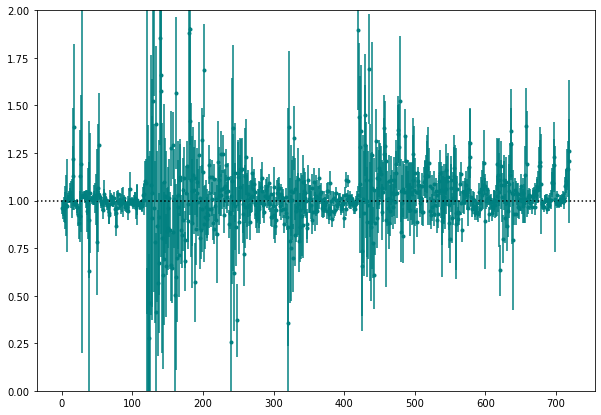

In [33]:
plt.figure(figsize=(10,7))
plt.errorbar(np.arange(len(data_total)), data_total/theory_total, np.sqrt(np.diag(cov_total))/theory_total,fmt='.', c='teal')
plt.ylim(0,2)
plt.axhline(y=1, color = 'k', ls = ':')

# Compare two different measurements

In [11]:
def plot_twopoint_compare_measurements(s, s2=None, theory_cov = None, datatype=None, ratios = False, diff = False, diff_with_errors=False):

        
    for dt in s.get_data_types():
        
        if dt == XIP or dt == XIM:
            nbins1 = nsbins
            nbins2 = nsbins
            name1 = 'source'
            name2 = 'source'
        
        if dt == GAMMA :
            nbins1 = nsbins
            nbins2 = nlbins
            name1 = 'source'
            name2 = 'lens'

        if dt == W:
            nbins1 = nlbins
            nbins2 = nlbins
            name1 = 'lens'
            name2 = 'lens'
            
        if dt == datatype:
        
            print(dt)
            plt.clf()


            fig, ax = plt.subplots(nbins1, nbins2, figsize=(2.2*nbins1, 2.2*nbins2), sharey=True, sharex=True)
            plt.subplots_adjust(wspace=0.1, hspace=0.1)

            for i in range(nbins1):
                for j in range(nbins2):

                    # this returns the JK cov
                    theta, xi, cov = s.get_theta_xi(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)
                    err = np.sqrt(np.diag(cov))

                    if theory_cov is not None:
                        _, _, cov = theory_cov.get_theta_xi(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)
                        err = np.sqrt(np.diag(cov))
                    
                    if s2 is not None:
                        theta2, xi2 = s2.get_theta_xi(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = False)

                    if ratios:
                        ax[i][j].errorbar(theta, xi2/xi, err/xi, fmt = '.',  capsize=1.5, elinewidth=0.8, color = c[1], label = 'Bin slop 0.05/Bin slop 0.01')

                    else:
                        
                        ax[i][j].errorbar(theta, xi, err, fmt = '.', capsize=1.5, elinewidth=0.8, color = c[1], label = 'Bin slop 0.01')
                        ax[i][j].errorbar(theta2, xi2, err, fmt = '.', capsize=1.5, elinewidth=0.8, color = c[3], label = 'Bin slop 0.05')
                    if (datatype==XIP) or (datatype==XIM) or ((datatype==W or datatype==GAMMA) and j>0 or i>0):
                        ax[i][j].text(0.5, 0.88, "(%d, %d)"%(i+1, j+1), horizontalalignment='center',
                                      verticalalignment='center', transform=ax[i][j].transAxes)#, fontsize=12)
                    ax[i][j].set_xscale('log')
                    ax[i][j].set_xlim(2, 270)
                    if datatype==W or datatype==GAMMA:
                        ax[i][j].axvspan(2, scale_cuts_6[j], color='lightgrey', alpha = 0.3)

                    if ratios:
                        ax[i][j].set_ylim(0.6, 1.4)
                        ax[i][j].axhline(y =1, ls = ':', color = 'k')
                    elif diff:
                        ax[i][j].set_ylim(-0.00001, 0.000005)
                        ax[i][j].axhline(y =0, ls = ':', color = 'k')
                    elif diff_with_errors:
                        ax[i][j].set_ylim(-3, 3.)
                        ax[i][j].axhline(y =0, ls = ':', color = 'k')
                    else:
                        ax[i][j].set_yscale('log')
                        if datatype==XIP:
                            ax[i][j].set_ylim(4*10**(-7), 10**(-4))
                        if datatype==XIM:
                            ax[i][j].set_ylim(2*10**(-7), 10**(-4))  
                        if datatype==GAMMA:
                            ax[i][j].set_ylim(5*10**(-7), 2*10**(-4))  
                        if datatype==W:
                            ax[i][j].set_ylim(10**(-6), 0.01)  


                    if i==nsbins-1: 
                        ax[i][j].set_xlabel(r'$\theta$ [arcmin]')
                    if j==0:
                        if datatype==XIP:
                            ax[i][j].set_ylabel(r'$\xi_+$')
                        if datatype==XIM:
                            ax[i][j].set_ylabel(r'$\xi_-$')
                        if datatype==GAMMA:
                            ax[i][j].set_ylabel(r'$\gamma_t$')
                        if datatype==W:
                            ax[i][j].set_ylabel(r'$w(\theta)$')
                            
                    if i<j:
                        fig.delaxes(ax[i, j])

    ax[0][0].legend(frameon = False, loc = 'best')

    return fig


# Plot measurements now

In [12]:
def plot_twopoint(s, theory=None, theory_cov = None, datatype=None, ratios = False, diff = False, diff_with_errors=False):

        
    for dt in s.get_data_types():
        
        if dt == XIP or dt == XIM:
            nbins1 = nsbins
            nbins2 = nsbins
            name1 = 'source'
            name2 = 'source'
        
        if dt == GAMMA :
            nbins1 = nsbins
            nbins2 = nlbins
            name1 = 'source'
            name2 = 'lens'

        if dt == W:
            nbins1 = nlbins
            nbins2 = nlbins
            name1 = 'lens'
            name2 = 'lens'
            
        if dt == datatype:
        
            print(dt)
            plt.clf()


            fig, ax = plt.subplots(nbins1, nbins2, figsize=(2.2*nbins1, 2.2*nbins2), sharey=True, sharex=True)
            plt.subplots_adjust(wspace=0.1, hspace=0.1)

            for i in range(nbins1):
                for j in range(nbins2):

                    # this returns the JK cov
                    theta, xi, cov = s.get_theta_xi(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)
                    err = np.sqrt(np.diag(cov))

                    if dt == GAMMA:
                        xi = xi*sims_factor[j]
                    if dt == W:
                        xi = xi*(sims_factor[j]*sims_factor[i])
                        

                    if theory_cov is not None:
                        _, _, cov = theory_cov.get_theta_xi(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)
                        err = np.sqrt(np.diag(cov))
                    
                    if theory is not None:
                        theta_th, xi_th = theory.get_theta_xi(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = False)

                    if ratios:
                        ax[i][j].errorbar(theta, xi/xi_th, err/xi_th, fmt = '.',  capsize=1.5, elinewidth=0.8, color = c[1], label = 'Measurement/Theory')
                    elif diff:
                        ax[i][j].errorbar(theta, xi-xi_th, fmt = '.',  capsize=1.5, elinewidth=0.8, color = c[1], label = 'Measurement-Theory')
                        ax[i][j].fill_between(theta, -err, err, alpha = 0.5, color = 'powderblue')
                    elif diff_with_errors:
                        q = (xi-xi_th)/err
                        sigma_cut = 1.
                        cut = np.abs(q)>sigma_cut
                        mask = None
                        for k in range(len(cut)):
                            if cut[len(cut)-k-1]==True and cut[len(cut)-k-2]==True and cut[len(cut)-k-3]==True:
                                mask = theta>theta[len(cut)-k-1]
                                break
                        if mask is None:
                            ax[i][j].plot(theta, q,   color = c[1], label = '(Measurement-Theory)/$\sigma$', alpha = 1.)
                            ax[i][j].plot(theta, q,   color = c[1], alpha = 0.33)
                            ax[i][j].plot(theta[mask], q[mask],   color = c[1], label = '(Measurement-Theory)/$\sigma$', alpha = 1.)
                            
                            
                        ax[i][j].fill_between(theta, -sigma_cut, sigma_cut, alpha = 0.33, color = 'powderblue')
                    else:
                        ax[i][j].plot(theta_th, xi_th, ls = '-', lw = '1.5', color = 'gray', label ='Theory')
                        #print('xi_th', i, j, xi_th)
                        ax[i][j].errorbar(theta, xi, err, fmt = '.', capsize=1.5, elinewidth=0.8, color = c[1], label = 'Measurements')
                    if (datatype==XIP) or (datatype==XIM) or ((datatype==W or datatype==GAMMA) and j>0 or i>0):
                        ax[i][j].text(0.5, 0.88, "(%d, %d)"%(i+1, j+1), horizontalalignment='center',
                                      verticalalignment='center', transform=ax[i][j].transAxes)#, fontsize=12)
                    ax[i][j].set_xscale('log')
                    ax[i][j].set_xlim(2, 270)
                    if datatype==W or datatype==GAMMA:
                        ax[i][j].axvspan(2, scale_cuts_srd[j], color='lightgrey', alpha = 0.3)

                    if ratios:
                        ax[i][j].set_ylim(0.6, 1.4)
                        ax[i][j].axhline(y =1, ls = ':', color = 'k')
                    elif diff:
                        ax[i][j].set_ylim(-0.00001, 0.000005)
                        ax[i][j].axhline(y =0, ls = ':', color = 'k')
                    elif diff_with_errors:
                        ax[i][j].set_ylim(-3, 3.)
                        ax[i][j].axhline(y =0, ls = ':', color = 'k')
                    else:
                        ax[i][j].set_yscale('log')
                        if datatype==XIP:
                            ax[i][j].set_ylim(4*10**(-7), 10**(-4))
                        if datatype==XIM:
                            ax[i][j].set_ylim(2*10**(-7), 10**(-4))  
                        if datatype==GAMMA:
                            ax[i][j].set_ylim(5*10**(-6), 2*10**(-3))  
                        if datatype==W:
                            ax[i][j].set_ylim(10**(-5), 0.1)  


                    if i==nsbins-1: 
                        ax[i][j].set_xlabel(r'$\theta$ [arcmin]')
                    if j==0:
                        if datatype==XIP:
                            ax[i][j].set_ylabel(r'$\xi_+$')
                        if datatype==XIM:
                            ax[i][j].set_ylabel(r'$\xi_-$')
                        if datatype==GAMMA:
                            ax[i][j].set_ylabel(r'$\gamma_t$')
                        if datatype==W:
                            ax[i][j].set_ylabel(r'$w(\theta)$')
                            
                    if i<j:
                        fig.delaxes(ax[i, j])

    ax[0][0].legend(frameon = False, loc = 'best')

    return fig


galaxy_density_xi


/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/sacc/sacc.py:370: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "


<Figure size 432x288 with 0 Axes>

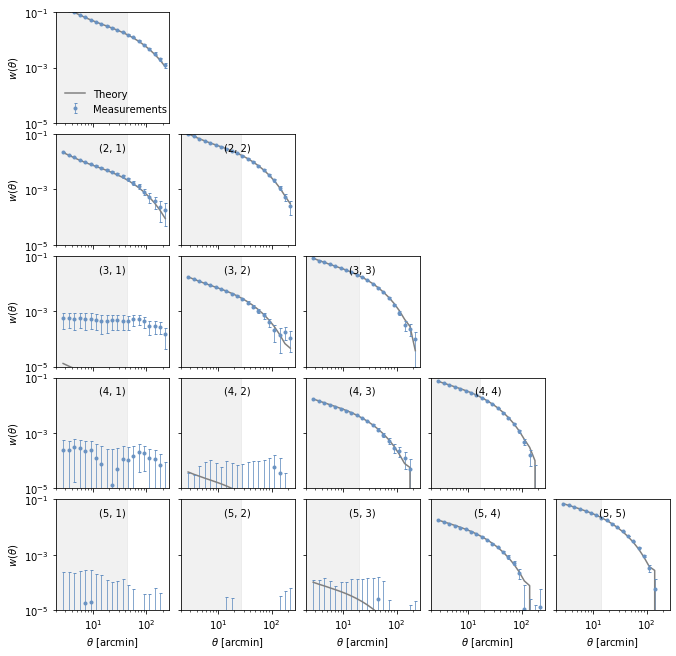

In [13]:
fig = plot_twopoint(d, theory=t,  theory_cov = t_cov_s, datatype=W, ratios = False, diff = False, diff_with_errors=False)
plt.savefig(dir + 'plots/' + 'wtheta.png', dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)
plt.savefig(dir + 'plots/' + 'wtheta.pdf', bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_density_xi


/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/sacc/sacc.py:370: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide
/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3370: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]
/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3371: RuntimeWarning: invalid value encountered in double_scalars
  high = [v + e for v, e in zip(data, b)]


<Figure size 432x288 with 0 Axes>

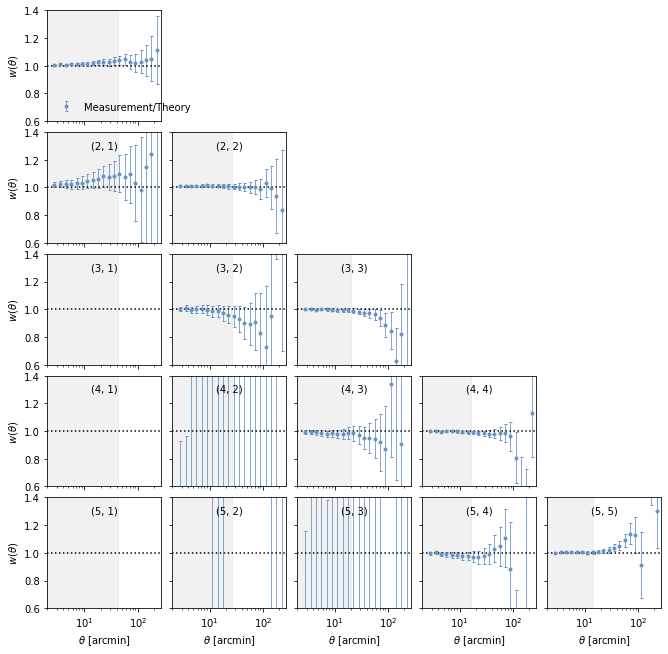

In [14]:
fig = plot_twopoint(d, theory=t,  theory_cov = t_cov_s, datatype=W, ratios = True, diff = False, diff_with_errors=False)
plt.savefig(dir + 'plots/' + 'wtheta_ratios.png', dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)
plt.savefig(dir + 'plots/' + 'wtheta_ratios.pdf', bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shearDensity_xi_t


<Figure size 432x288 with 0 Axes>

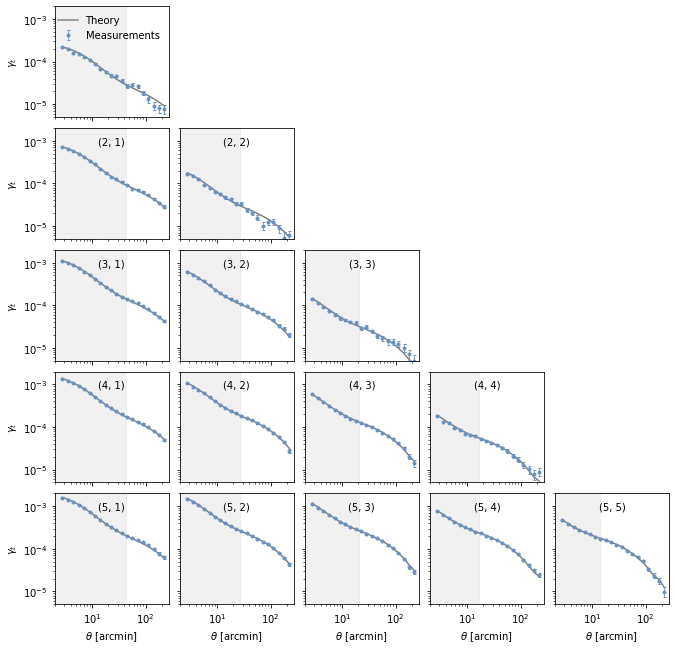

In [15]:
fig = plot_twopoint(d, theory=t,  theory_cov = t_cov_s, datatype=GAMMA, ratios = False, diff = False, diff_with_errors=False)
plt.savefig(dir + 'plots/' + 'gammat.png', dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)
plt.savefig(dir + 'plots/' + 'gammat.pdf', bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shearDensity_xi_t


/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide
/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3370: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]
/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3371: RuntimeWarning: invalid value encountered in double_scalars
  high = [v + e for v, e in zip(data, b)]


<Figure size 432x288 with 0 Axes>

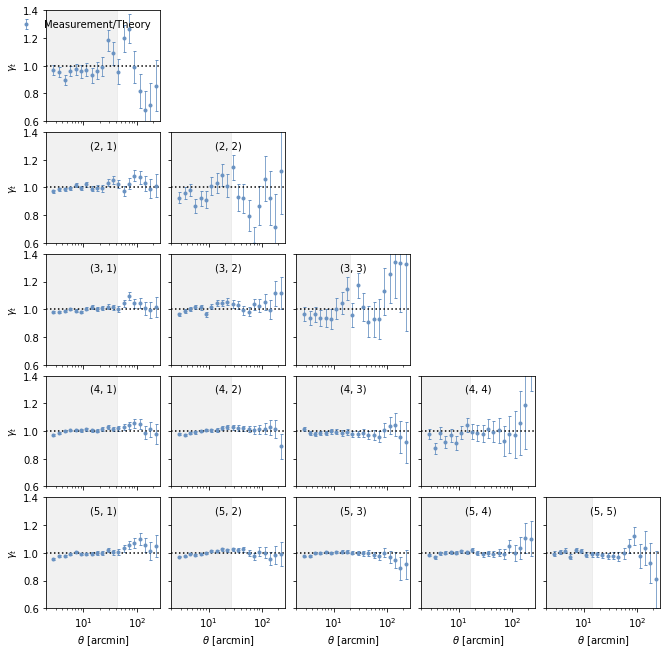

In [16]:
fig = plot_twopoint(d, theory=t,  theory_cov = t_cov_s, datatype=GAMMA, ratios = True, diff = False, diff_with_errors=False)
plt.savefig(dir + 'plots/' + 'gammat_ratios.png', dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)
plt.savefig(dir + 'plots/' + 'gammat_ratios.pdf', bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shear_xi_plus


/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/sacc/sacc.py:370: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "


<Figure size 432x288 with 0 Axes>

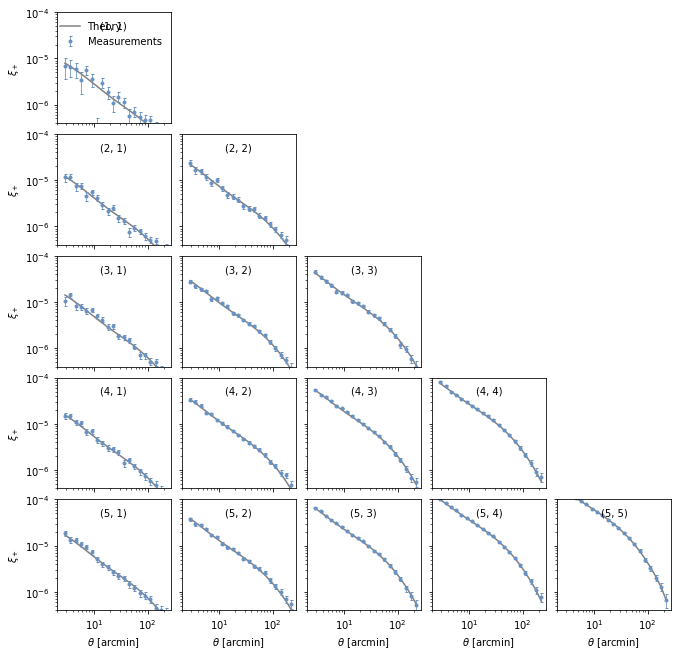

In [17]:
fig = plot_twopoint(d, theory=t,  theory_cov = t_cov_s, datatype=XIP, ratios = False, diff = False, diff_with_errors=False)
plt.savefig(dir + 'plots/' + 'xip.png', dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)
plt.savefig(dir + 'plots/' + 'xip.pdf', bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shear_xi_minus


/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/sacc/sacc.py:370: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "


<Figure size 432x288 with 0 Axes>

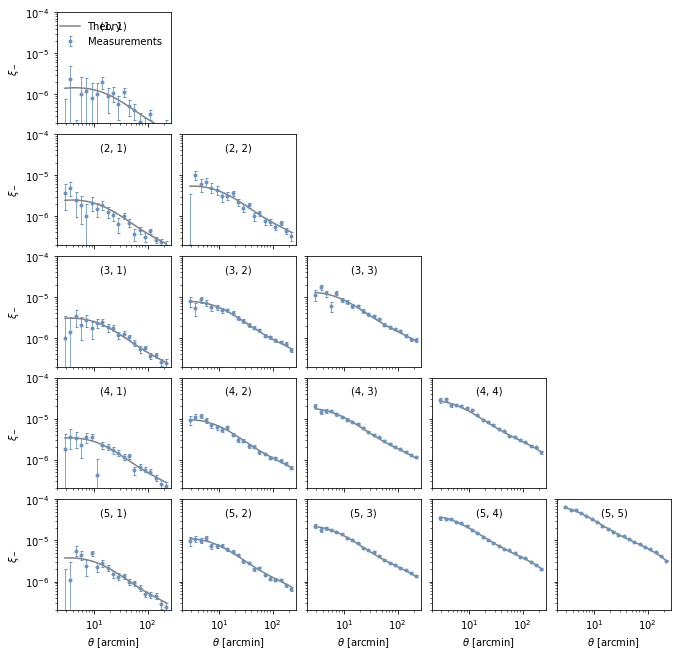

In [18]:
fig = plot_twopoint(d, theory=t,  theory_cov = t_cov_s, datatype=XIM, ratios = False, diff = False, diff_with_errors=False)
plt.savefig(dir + 'plots/' + 'xim.png', dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)
plt.savefig(dir + 'plots/' + 'xim.pdf', bbox_inches = 'tight',  pad_inches = 0.1)

# Comparing errorbars now

In [34]:
def plot_errorbars(s, theory=None, theory_cov = None, theory_cov2 = None, datatype=None, ratios = False):
      
    for dt in s.get_data_types():
        if dt == XIP or dt == XIM:
            nbins1 = nsbins
            nbins2 = nsbins
            name1 = 'source'
            name2 = 'source'
        
        if dt == GAMMA:
            nbins1 = nsbins
            nbins2 = nlbins
            name1 = 'source'
            name2 = 'lens'

        if dt == W:
            nbins1 = nlbins
            nbins2 = nlbins
            name1 = 'lens'
            name2 = 'lens'
            
        if dt == datatype:
            print(dt)
            plt.clf()
            fig, ax = plt.subplots(nbins1, nbins2, figsize=(2.2*nbins1, 2.2*nbins2), sharey=True, sharex=True)
            plt.subplots_adjust(wspace=0.1, hspace=0.1)

            count =-1
            for i in range(nbins1):
                for j in range(nbins2):
                    
                    theta, _, cov = s.get_theta_xi(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)
                    err = np.sqrt(np.diag(cov))
                    
                    if dt == GAMMA:
                        err = err*sims_factor[j]
                    if dt == W:
                        err = err*sims_factor[j]*sims_factor[i]
                        
                    if theory is not None:
                        theta_th,  _ = theory.get_theta_xi(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j))
                        if theory_cov is not None:
                            _, _, cov_th = theory_cov.get_theta_xi(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)
                            err_th = np.sqrt(np.diag(cov_th))
                        
                        if theory_cov2 is not None:
                            _, _, cov_th2 = theory_cov2.get_theta_xi(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)
                            err_th2 = np.sqrt(np.diag(cov_th2))                       
                        

                    if ratios:
                       
                        ax[i][j].plot(theta, err/err_th, lw = 2,ls = '-', color = c[1], label = 'JK/Theory')
                        if theory_cov2 is not None:
                            ax[i][j].plot(theta, err_th/err_th2, lw = 2,ls = '-', color = c[3], label = 'Higher shot noise/SRD shot noise')
                    else:
                        ax[i][j].plot(theta, err, lw = 2, color = c[0], label = 'Jackknife')
                        
                        ax[i][j].plot(theta, err_th, lw = 2,color = c[1],  label = 'Theory scaled shot noise')  
                        if theory_cov2 is not None:
                            ax[i][j].plot(theta, err_th2, lw = 2,color = c[1], ls='--', label = 'Theory')

                    ax[i][j].text(0.5, 0.88, "(%d, %d)"%(i+1, j+1), horizontalalignment='center',
                                  verticalalignment='center', transform=ax[i][j].transAxes)#, fontsize=12)
                    ax[i][j].set_xscale('log')
                    ax[i][j].set_xlim(2, 270)
                    if datatype==W or datatype==GAMMA:
                        ax[i][j].axvspan(2, scale_cuts_srd[j], color='lightgray', alpha = 0.3)
                    
                    if ratios:
                        ax[i][j].set_ylim(0.8, 1.2)
                        ax[i][j].axhline(y =1, ls = ':', color = 'k')
                    else:
                        ax[i][j].set_yscale('log')
                        if datatype==XIP:
                            ax[i][j].set_ylim(10**(-7), 10**(-5))
                        if datatype==XIM:
                            ax[i][j].set_ylim(10**(-7), 10**(-5))  
                        if datatype==GAMMA:
                            ax[i][j].set_ylim(10**(-6), 10**(-5))  
                        if datatype==W:
                            ax[i][j].set_ylim(10**(-5),2*10**(-3))  


                    if i==nsbins-1: 
                        ax[i][j].set_xlabel(r'$\theta$ [arcmin]')
                    if j==0:
                        if datatype==XIP:
                            ax[i][j].set_ylabel(r'$\sigma(\xi_+$)')
                        if datatype==XIM:
                            ax[i][j].set_ylabel(r'$\sigma(\xi_-$)')
                        if datatype==GAMMA:
                            ax[i][j].set_ylabel(r'$\sigma(\gamma_t$)')
                        if datatype==W:
                            ax[i][j].set_ylabel(r'$\sigma(w(\theta))$')
                            
                    if datatype!=GAMMA:
                        if i<j:
                            fig.delaxes(ax[i, j])

                ax[0][0].legend(frameon = True, loc = 'lower left', fontsize = 10)

    return fig


galaxy_shear_xi_plus


/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/sacc/sacc.py:370: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "


<Figure size 432x288 with 0 Axes>

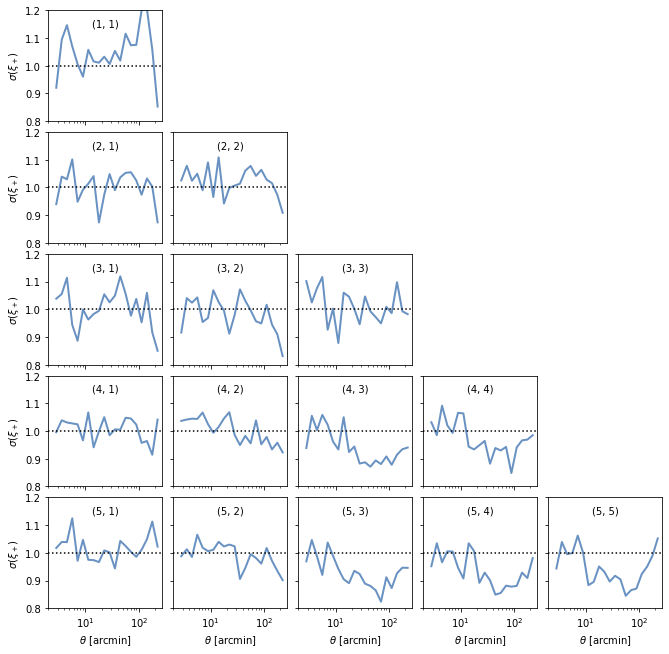

In [9]:
fig = plot_errorbars(d, theory=t, theory_cov = t_cov_s, datatype=XIP, ratios = True)
plt.savefig(dir + 'plots/' + 'xip_errors_ratio.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shear_xi_plus


<Figure size 432x288 with 0 Axes>

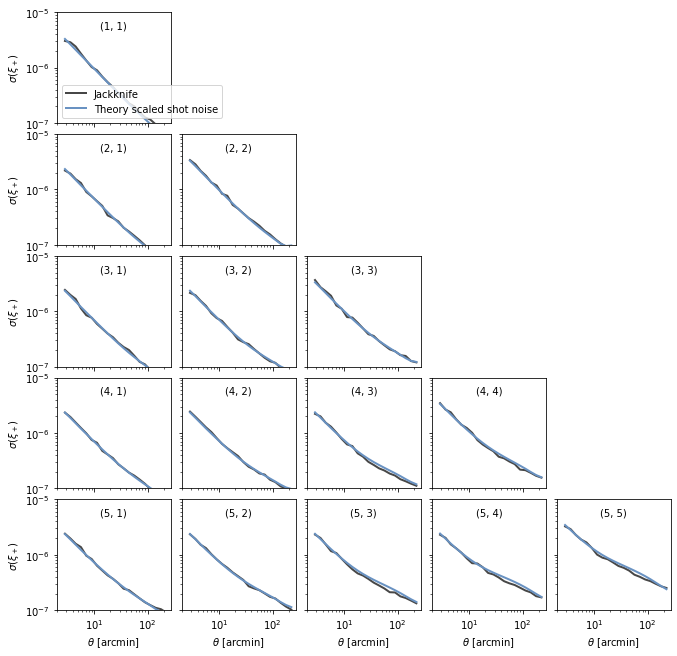

In [18]:
fig = plot_errorbars(d, theory=t, theory_cov = t_cov_s,  datatype=XIP, ratios = False)
plt.savefig(dir + 'plots/' + 'xip_errors.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shear_xi_minus


<Figure size 432x288 with 0 Axes>

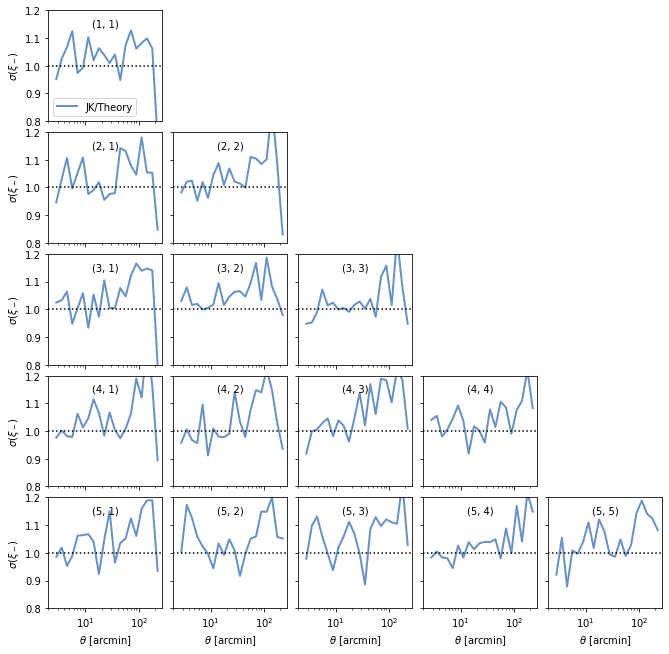

In [19]:
fig = plot_errorbars(d, theory=t, theory_cov = t_cov_s,  datatype=XIM, ratios = True)
plt.savefig(dir + 'plots/' + 'xim_errors_ratio.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shear_xi_minus


<Figure size 432x288 with 0 Axes>

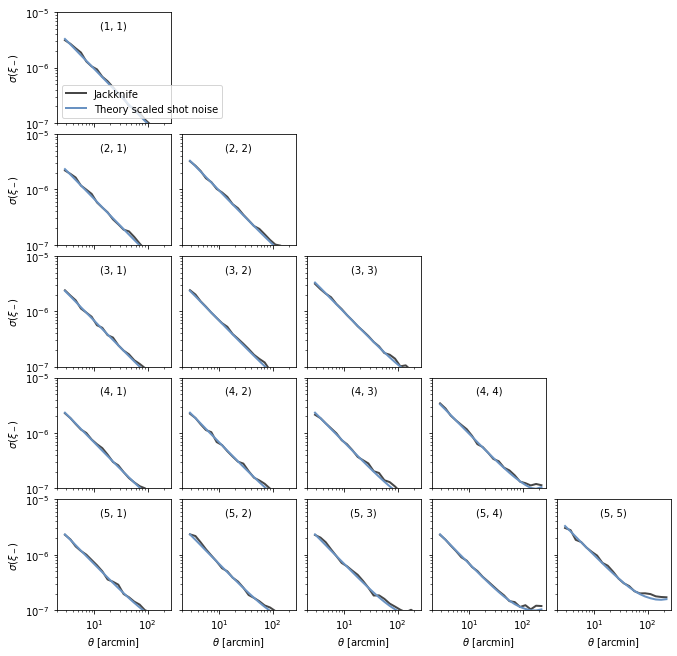

In [20]:
fig = plot_errorbars(d, theory=t, theory_cov = t_cov_s,  datatype=XIM, ratios = False)
plt.savefig(dir + 'plots/' + 'xim_errors.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shearDensity_xi_t


<Figure size 432x288 with 0 Axes>

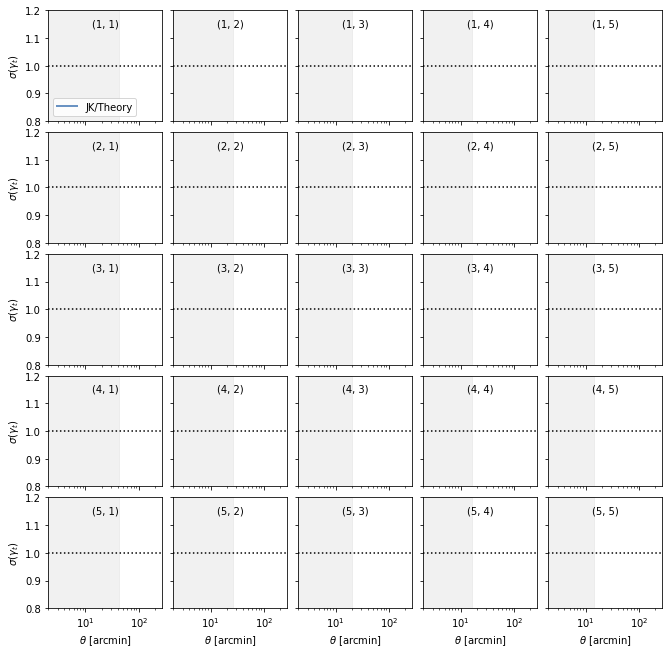

In [26]:
fig = plot_errorbars(d, theory=t, theory_cov = t_cov_s,datatype=GAMMA, ratios = True)
plt.savefig(dir + 'plots/' + 'gammat_errors_ratio.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shearDensity_xi_t


<Figure size 432x288 with 0 Axes>

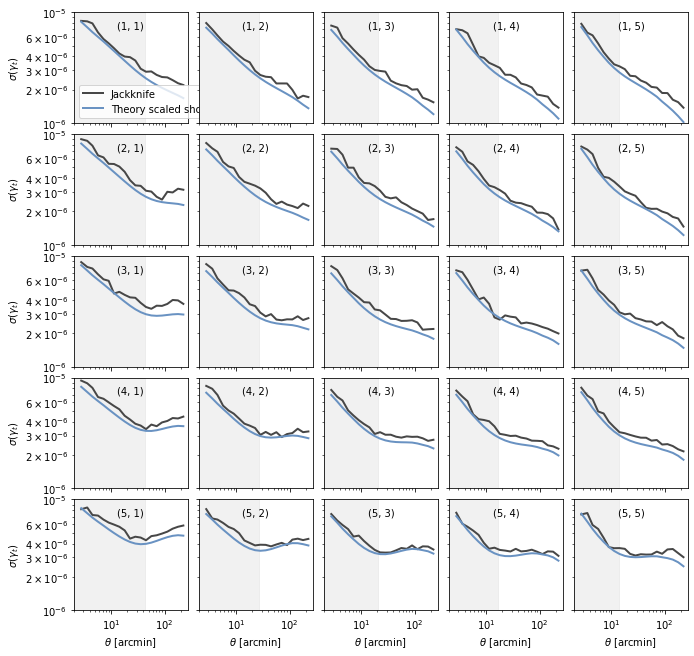

In [32]:
fig = plot_errorbars(d, theory=t, theory_cov = t_cov_s,  theory_cov2 = None, datatype=GAMMA, ratios = False)
plt.savefig(dir + 'plots/' + 'gammat_errors_scaled.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_density_xi


<Figure size 432x288 with 0 Axes>

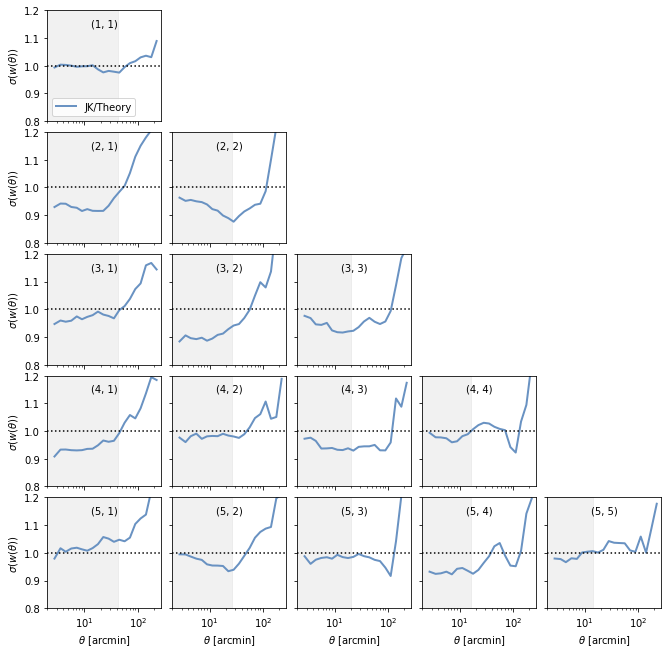

In [36]:
fig = plot_errorbars(d, theory=t, theory_cov = t_cov_s, datatype=W, ratios = True)
plt.savefig(dir + 'plots/' + 'wtheta_errors_ratios.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_density_xi


<Figure size 432x288 with 0 Axes>

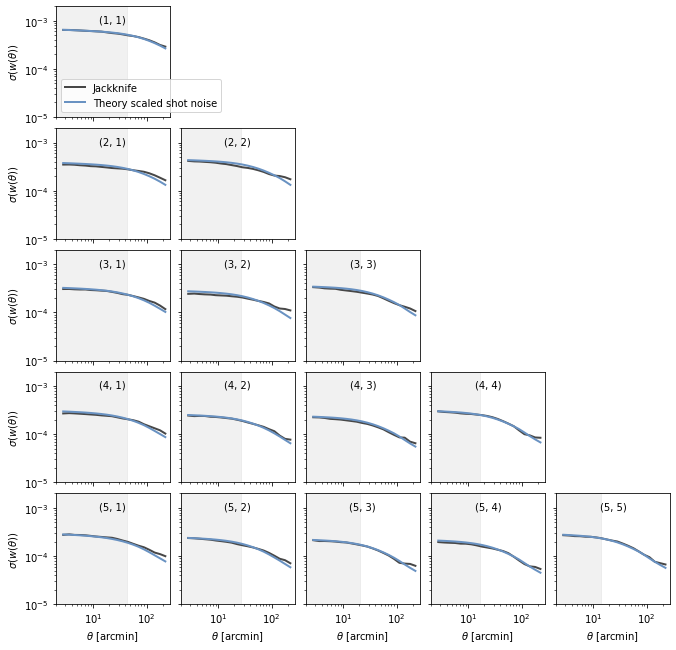

In [35]:
fig = plot_errorbars(d, theory=t, theory_cov = t_cov_s, datatype=W, ratios = False)
plt.savefig(dir + 'plots/' + 'wtheta_errors.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

# Some cross-checks: gammax

In [61]:
def plot_gammax(s):        
    
    nbins1 = nsbins
    nbins2 = nlbins
    name1 = 'source'
    name2 = 'lens'

    fig, ax = plt.subplots(nbins1, nbins2, figsize=(2.2*nbins1, 3.2*nbins2), sharey=True, sharex=True)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    for i in range(nbins1):
        for j in range(nbins2):

            # this returns the JK cov
            theta, xi, cov = s.get_theta_xi('galaxy_shearDensity_xi_x','%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)   
            err = np.sqrt(np.diag(cov))
                    
            ax[i][j].errorbar(theta, xi*theta, err*theta, fmt = '.', capsize=1.5, elinewidth=0.8, color = c[0], label = 'Measurements')
            ax[i][j].text(0.5, 0.88, "(%d, %d)"%(i+1, j+1), horizontalalignment='center',
                            verticalalignment='center', transform=ax[i][j].transAxes)#, fontsize=12)
            ax[i][j].set_xscale('log')
            ax[i][j].set_xlim(2, 270)
            ax[i][j].set_ylim(-0.0003, 0.0003)
            ax[i][j].axhline(y=0, color = 'k', ls = ':')      

            if i==nsbins-1: 
                ax[i][j].set_xlabel(r'$\theta$ [arcmin]')
            if j==0:
                ax[i][j].set_ylabel(r'$\gamma_\times \times \theta$')

    ax[0][0].legend(frameon = False, loc = 'best')

    return fig


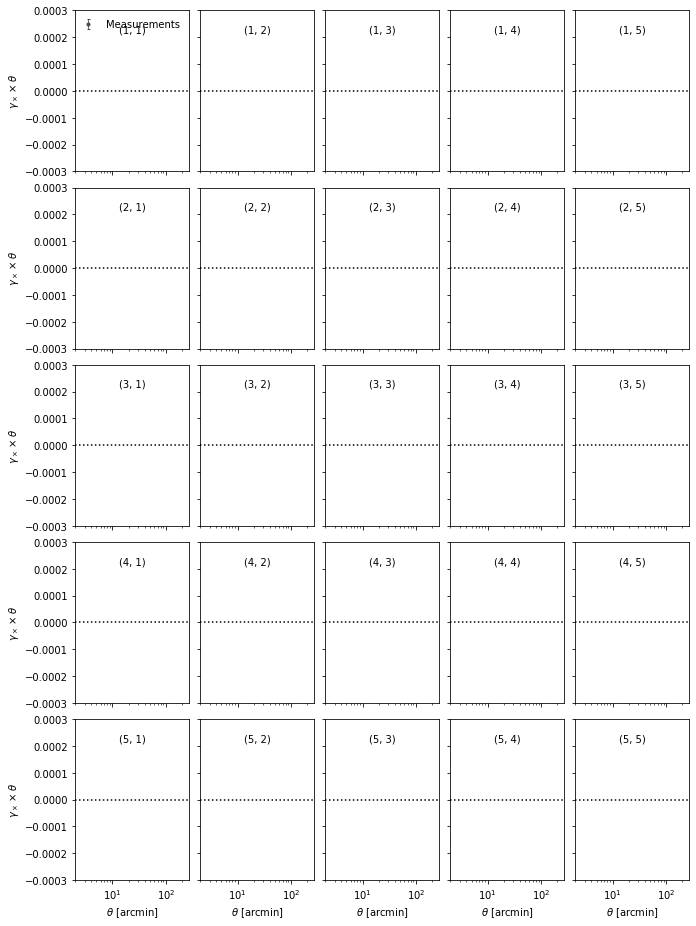

In [66]:
covname = 'JK'
fig = plot_gammax(d)
plt.savefig(dir + 'plots/' + 'gammax_%s'%covname, dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

# Plot covariances now

In [45]:
def corrmatrix(cov):
    cov = np.mat(cov)
    D = np.diag(np.sqrt(np.diag(cov)))
    d = np.linalg.inv(D)
    corr = d*cov*d
    return corr

def plot_cov(cov, size):
    
    ncov1 = len(cov)
    ncov2 = len(cov[0])
    
    corr = corrmatrix(cov)
    cov_vmin = np.min(corr)
    
    figsize1 = 1.22222222227*ncov1/size
    figsize2 = ncov2/size
    fig, ax = plt.subplots(1, 1, figsize=(figsize1, figsize2))
    im = ax.imshow(corr, interpolation='nearest',
                           aspect='auto', origin='lower', vmin=-0.5, vmax=1.)
    cbar = fig.colorbar(im)
    return fig

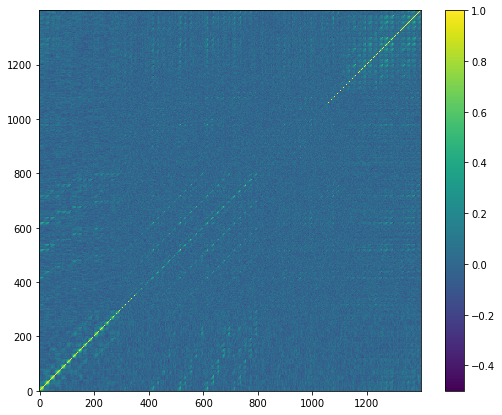

In [46]:
cov = plot_cov(d.covariance.covmat, 200)
plt.savefig(dir + 'plots/cov_3x2pt_JK.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

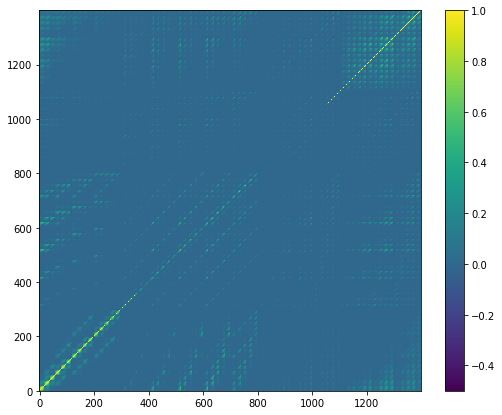

In [52]:
cov = plot_cov(t_cov_s.covariance.covmat, 200)
plt.savefig(dir + 'plots/cov_3x2pt_theory.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

In [53]:
d.covariance.covmat.shape

(1400, 1400)

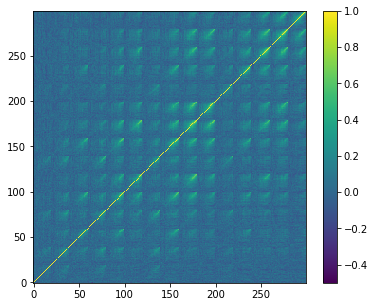

In [54]:
indices_p = d.indices('galaxy_shear_xi_plus')
cov = plot_cov(d.covariance.get_block(indices_p), 60)
plt.savefig(dir + 'plots/cov_xip_JK.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

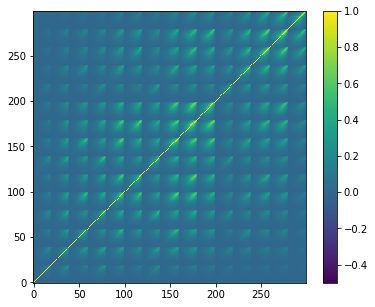

In [57]:
indices_p = t_cov_s.indices('galaxy_shear_xi_plus')
cov = plot_cov(t_cov_s.covariance.get_block(indices_p), 60)
plt.savefig(dir + 'plots/cov_xip_theory.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

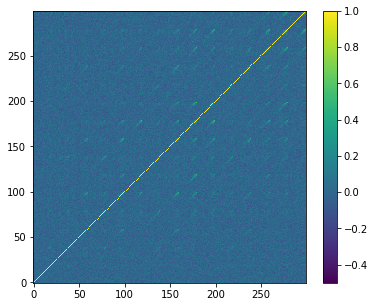

In [58]:
indices_p = d.indices('galaxy_shear_xi_minus')
cov = plot_cov(d.covariance.get_block(indices_p), 60)
plt.savefig(dir + 'plots/cov_xim_JK.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

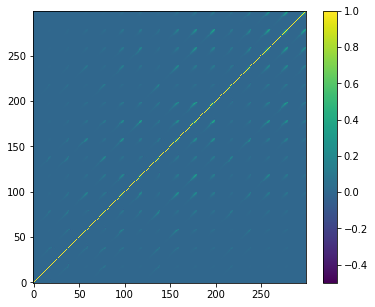

In [59]:
indices_p = t_cov_s.indices('galaxy_shear_xi_minus')
cov = plot_cov(t_cov_s.covariance.get_block(indices_p), 60)
plt.savefig(dir + 'plots/cov_xim_theory.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

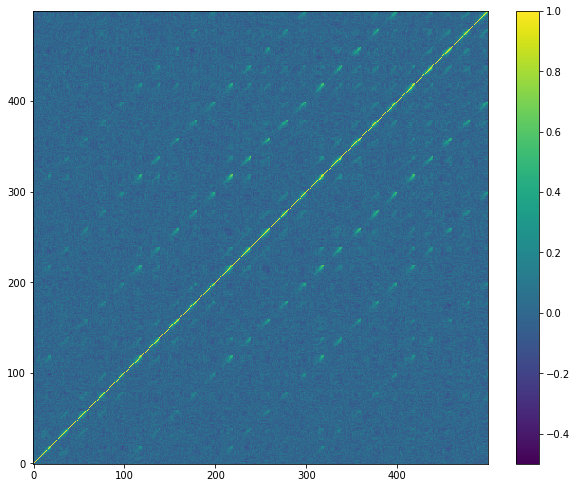

In [62]:
indices = d.indices(GAMMA)
cov = plot_cov(d.covariance.get_block(indices), 60)
plt.savefig(dir + 'plots/cov_gt_JK.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

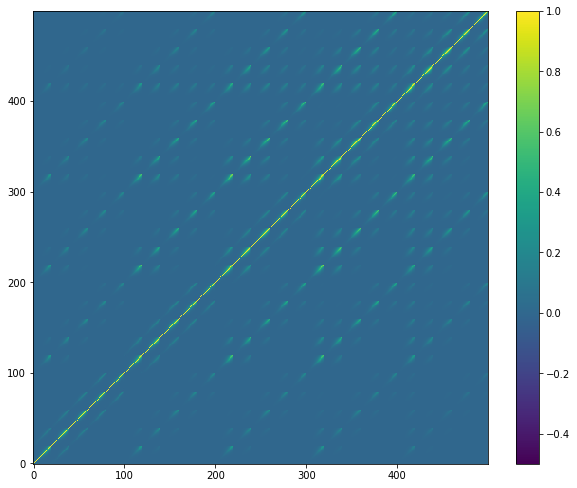

In [61]:
indices = t_cov_s.indices(GAMMA)
cov = plot_cov(t_cov_s.covariance.get_block(indices), 60)
plt.savefig(dir + 'plots/cov_gt_theory.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

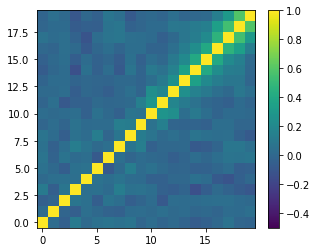

In [68]:
indices = d.indices(GAMMA)
cov = plot_cov((d.covariance.get_block(indices)[0:20]).T[0:20], 5)
plt.savefig(dir + 'plots/cov_gt_JK_block.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

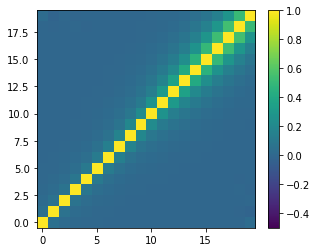

In [71]:
indices = t_cov_s.indices(GAMMA)
cov = plot_cov((t_cov_s.covariance.get_block(indices)[0:20]).T[0:20], 5)
plt.savefig(dir + 'plots/cov_gt_theory_block.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

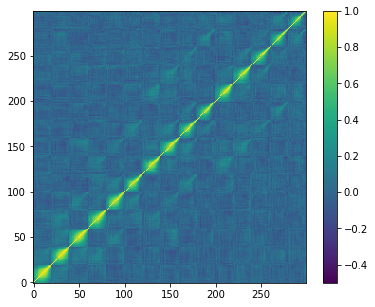

In [63]:
indices = d.indices(W)
cov = plot_cov(d.covariance.get_block(indices), 60)
plt.savefig(dir + 'plots/cov_w_JK.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

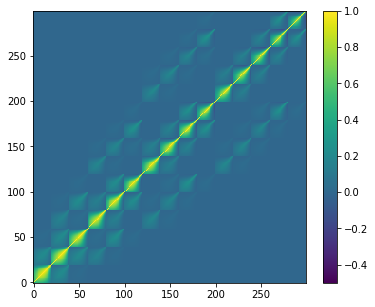

In [64]:
indices = t_cov_s.indices(W)
cov = plot_cov(t_cov_s.covariance.get_block(indices), 60)
plt.savefig(dir + 'plots/cov_w_theory.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

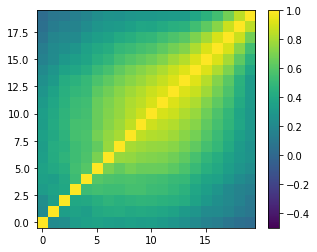

In [73]:
indices = d.indices(W)
cov = plot_cov((d.covariance.get_block(indices)[0:20]).T[0:20], 5)
plt.savefig(dir + 'plots/cov_w_JK_block.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

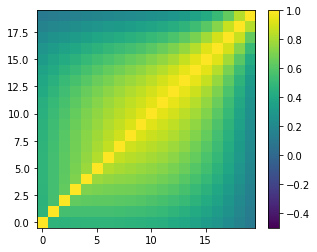

In [74]:
indices = t_cov_s.indices(W)
cov = plot_cov((t_cov_s.covariance.get_block(indices)[0:20]).T[0:20], 5)
plt.savefig(dir + 'plots/cov_w_theory_block.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)